In [1]:
# Importing the relevant packages
import tensorflow as tf
import tensorflow_datasets as tfds

## Downloading and preprocessing the data

In [3]:
# Before continuing with our model and training, our first job is to preprocess the dataset
# This is a very important step in all of machine learning

# The MNIST dataset is, in general, highly processed already - after all its 28x28 grayscale images of clearly visible digits
# Thus, our preprocessing will be limited to scaling the pixel values, shuffling the data and creating a validation set

# NOTE: When finally deploying a model in practice, it might be a good idea to include the prerpocessing as initial layers
# In that way, the users could just plug the data (images) directly, instead of being required to resize/rescale it before

In [4]:
# Defining some constants/hyperparameters
BUFFER_SIZE = 70_000 # for reshuffling
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [5]:
# Downloading the MNIST dataset

# When 'with_info' is set to True, tfds.load() returns two variables: 
# - the dataset (including the train and test sets) 
# - meta info regarding the dataset itself

mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

In [6]:
# Extracting the train and test datasets
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

In [7]:
# Creating a function to scale our image data (it is recommended to scale the pixel values in the range [0,1] )
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.

    return image, label

In [8]:
# Scaling the data
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [9]:
# Defining the size of the validation set
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [10]:
# Defining the size of the test set
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [11]:
# Reshuffling the dataset
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [12]:
# Splitting the dataset into training + validation
train_data = train_and_validation_data.skip(num_validation_samples)
validation_data = train_and_validation_data.take(num_validation_samples)

In [13]:
# Batching the data
# NOTE: For proper functioning of the model, we need to create one big batch for the validation and test sets
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples) 
test_data = test_data.batch(num_test_samples)

## Creating the model and training it

In [15]:
# Now that we have preprocessed the dataset, we can define our CNN and train it

In [16]:
# Outlining the model/architecture of our CNN
# CONV -> MAXPOOL -> CONV -> MAXPOOL -> FLATTEN -> DENSE
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    # (2,2) is the default pool size so we could have just used MaxPooling2D() with no explicit arguments
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10) # You can apply softmax activation here, see below for comentary
])

C:\Users\informasud\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# A brief summary of the model and parameters
model.summary(line_length = 75)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape            ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                │ (None, 24, 24, 50)      │        1,300 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d (MaxPooling2D)   │ (None, 12, 12, 50)      │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ conv2d_1 (Conv2D)              │ (None, 10, 10, 50)      │       22,550 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d_1 (MaxPooling2D) │ (None, 5, 5, 50)        │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ flatten (Flatten)              │ (None, 1250)            │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dense (Dense)                  │ (None, 10)              │       12,510 │
└────────────────────────────────┴─────────────────────────┴──────────────┘

 Total params: 36,360 (142.03 KB)

 Trainable params: 36,360 (142.03 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Defining the loss function

# In general, our model needs to output probabilities of each class, 
# which can be achieved with a softmax activation in the last dense layer

# However, when using the softmax activation, the loss can rarely be unstable

# Thus, instead of incorporating the softmax into the model itself,
# we use a loss calculation that automatically corrects for the missing softmax

# That is the reason for 'from_logits=True'
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [19]:
# Compiling the model with Adam optimizer and the cathegorical crossentropy as a loss function
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [20]:
# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',    
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

In [21]:
# Train the network
model.fit(
    train_data, 
    epochs = NUM_EPOCHS, 
    callbacks = [early_stopping], 
    validation_data = validation_data,
    verbose = 2
)

Epoch 1/20
422/422 - 17s - 40ms/step - accuracy: 0.9237 - loss: 0.2689 - val_accuracy: 0.9752 - val_loss: 0.0824
Epoch 2/20
422/422 - 16s - 37ms/step - accuracy: 0.9785 - loss: 0.0721 - val_accuracy: 0.9820 - val_loss: 0.0589
Epoch 3/20
422/422 - 16s - 37ms/step - accuracy: 0.9836 - loss: 0.0546 - val_accuracy: 0.9838 - val_loss: 0.0487
Epoch 4/20
422/422 - 19s - 46ms/step - accuracy: 0.9870 - loss: 0.0437 - val_accuracy: 0.9895 - val_loss: 0.0349
Epoch 5/20
422/422 - 15s - 37ms/step - accuracy: 0.9886 - loss: 0.0367 - val_accuracy: 0.9923 - val_loss: 0.0237
Epoch 6/20
422/422 - 16s - 37ms/step - accuracy: 0.9901 - loss: 0.0317 - val_accuracy: 0.9893 - val_loss: 0.0315
Epoch 7/20
422/422 - 16s - 37ms/step - accuracy: 0.9921 - loss: 0.0267 - val_accuracy: 0.9950 - val_loss: 0.0224
Epoch 8/20
422/422 - 15s - 37ms/step - accuracy: 0.9924 - loss: 0.0244 - val_accuracy: 0.9942 - val_loss: 0.0180
Epoch 9/20
422/422 - 15s - 36ms/step - accuracy: 0.9931 - loss: 0.0220 - val_accuracy: 0.9957 - 

## Testing our model

In [23]:
# Testing our model
test_loss, test_accuracy = model.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9918 - loss: 0.0260


In [24]:
# Printing the test results
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.0260. Test accuracy: 99.18%


### Plotting images and the results

In [26]:
import matplotlib.pyplot as plt
import numpy as np

In [27]:
# Split the test_data into 2 arrays, containing the images and the corresponding labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

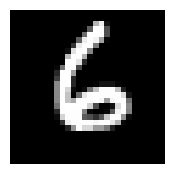

Label: 6


In [28]:
# The image to be displayed and tested
i = 100


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


<BarContainer object of 10 artists>

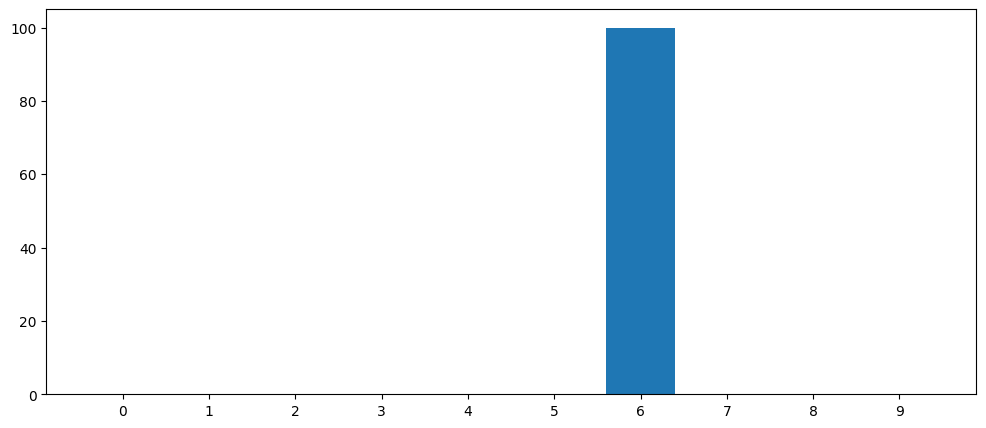

In [29]:
# Obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])